In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D

In [2]:
cifar100 = tf.keras.datasets.cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

169017344/169001437 [==============================] - 3s 0us/step


In [4]:
#checking the shape
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
#converting values to float 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [6]:
#normalizing
X_train=X_train/255
X_test=X_test/255

In [7]:
def timer(start_time=None):
  #function to track time 
  if not start_time:
      print(datetime.now())
      start_time = datetime.now()
      return start_time
  elif start_time:
      thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
      tmin, tsec = divmod(temp_sec, 60)
      print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

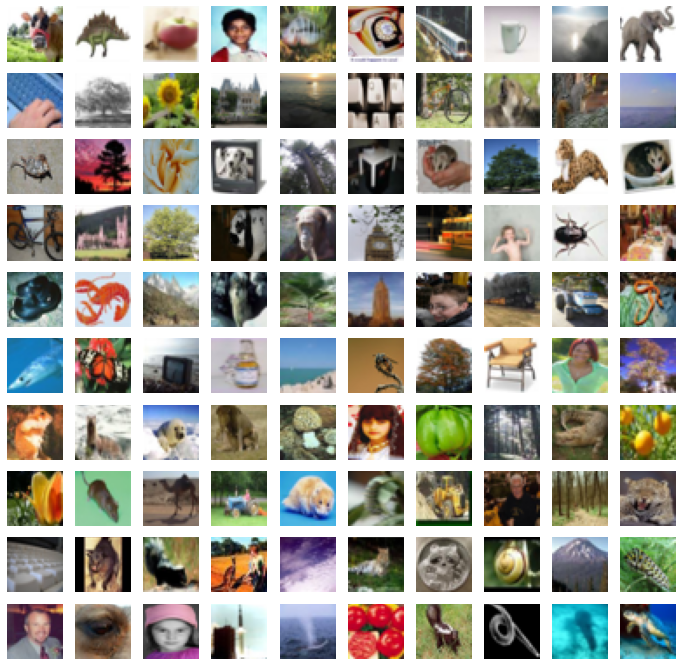

In [8]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_train, Y_train,test_size=0.2)

In [10]:
from keras.utils.np_utils import to_categorical
y_train=to_categorical(y_train,num_classes=100)
y_val=to_categorical(y_val,num_classes=100)
y_test=to_categorical(Y_test,num_classes=100)

In [11]:
  x_train = x_train * 1.0/255
  x_val = x_val * 1.0/255
  X_test = X_test * 1.0/255

In [12]:
print(x_train.shape, x_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


In [13]:
train_datagen = ImageDataGenerator( 
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,  
        vertical_flip = False
        )
train_datagen.fit(x_train)

In [14]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)

In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [16]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

In [19]:
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
start_time=timer(None)
result=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 50,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)
timer(start_time)

2021-08-18 10:06:13.502702
Epoch 1/50
  9/313 [..............................] - ETA: 7:01:38 - loss: 5.2214 - accuracy: 0.0087

In [ ]:
model.summary()

In [ ]:
plot_acc_loss(result)

In [ ]:
y_pred = model.predict_classes(X_test)
y_true = Y_test.ravel()
print(y_pred.shape)
print(y_true.shape)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cm